# **Blur Kernels**

In this notebook we explore image bluring kernels to apporximate camera motion

In [3]:
import os
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

### Obtain Test Image

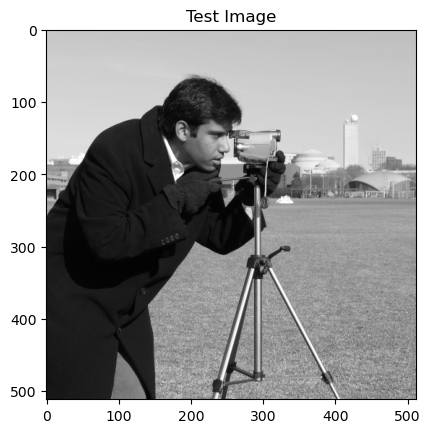

In [4]:
from skimage.data import camera

image = camera()/255

plt.imshow(image, cmap='gray')
plt.title("Test Image");

### Create Image Blur Kernels

In [97]:
# horizontal Blur
horz_blur = np.zeros((21, 21))
horz_blur = cv2.line(horz_blur, pt1=(21,10), pt2=(0,10), color=(255,), thickness=1)

# vertical Blur
vert_blur = np.zeros((21, 21))
vert_blur = cv2.line(vert_blur, pt1=(10,21), pt2=(10,0), color=(255,), thickness=1)

# diagonal blur (x and y)
diag_blur = np.zeros((21, 21))
diag_blur = cv2.line(diag_blur, pt1=(0,21), pt2=(21,0), color=(255,), thickness=1)

# box filter (averaging kernel)
box_filter = np.ones((21, 21))/21

# circular averaging kernel
circle_filter = cv2.circle(np.zeros((21, 21)), center=(10,10), radius=8, color=(255,), thickness=-1)

In [98]:
# kernels = [box_filter, horz_blur, vert_blur, diag_blur]
kernels = [circle_filter, horz_blur, vert_blur, diag_blur]

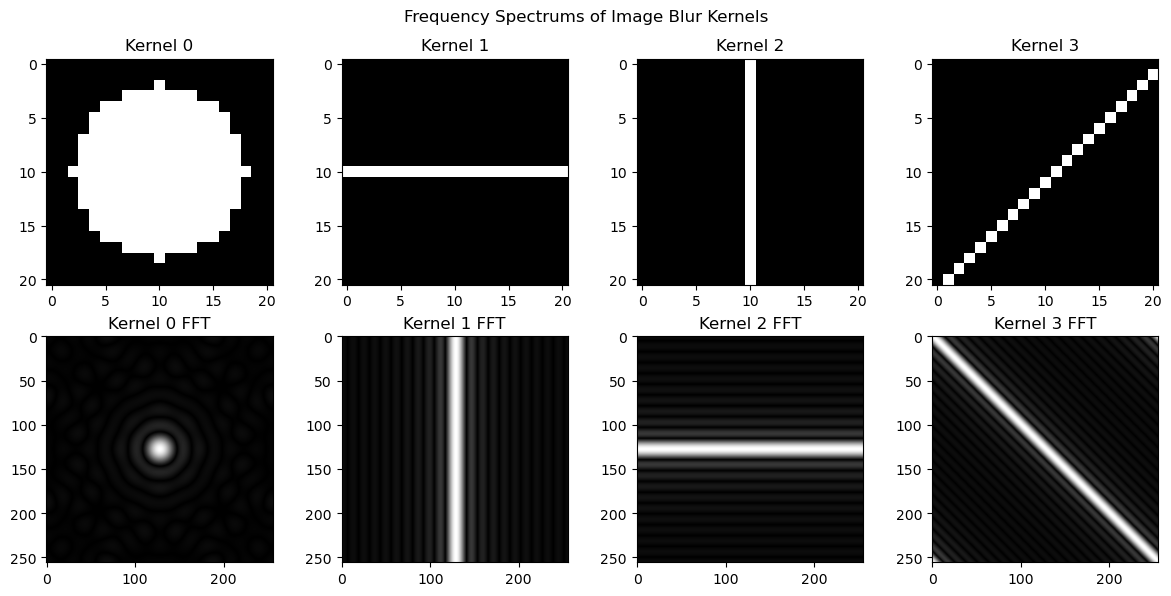

In [99]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

fig.suptitle("Frequency Spectrums of Image Blur Kernels")

for i, k in enumerate(kernels):
    # regular 
    k_fft = np.fft.fft2(kernels[i])

    # Zero Padded
    canvas = np.zeros((256, 256))
    h, w = kernels[i].shape
    canvas[0:h, 0:w] = kernels[i]
    k_fft = np.fft.fft2(canvas)
    

    ax[0][i].imshow(k, cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(np.abs(np.fft.fftshift(k_fft)), cmap='gray')
    ax[1][i].set_title(f"Kernel {i} FFT")

plt.tight_layout();

### Apply Blur to Test Image

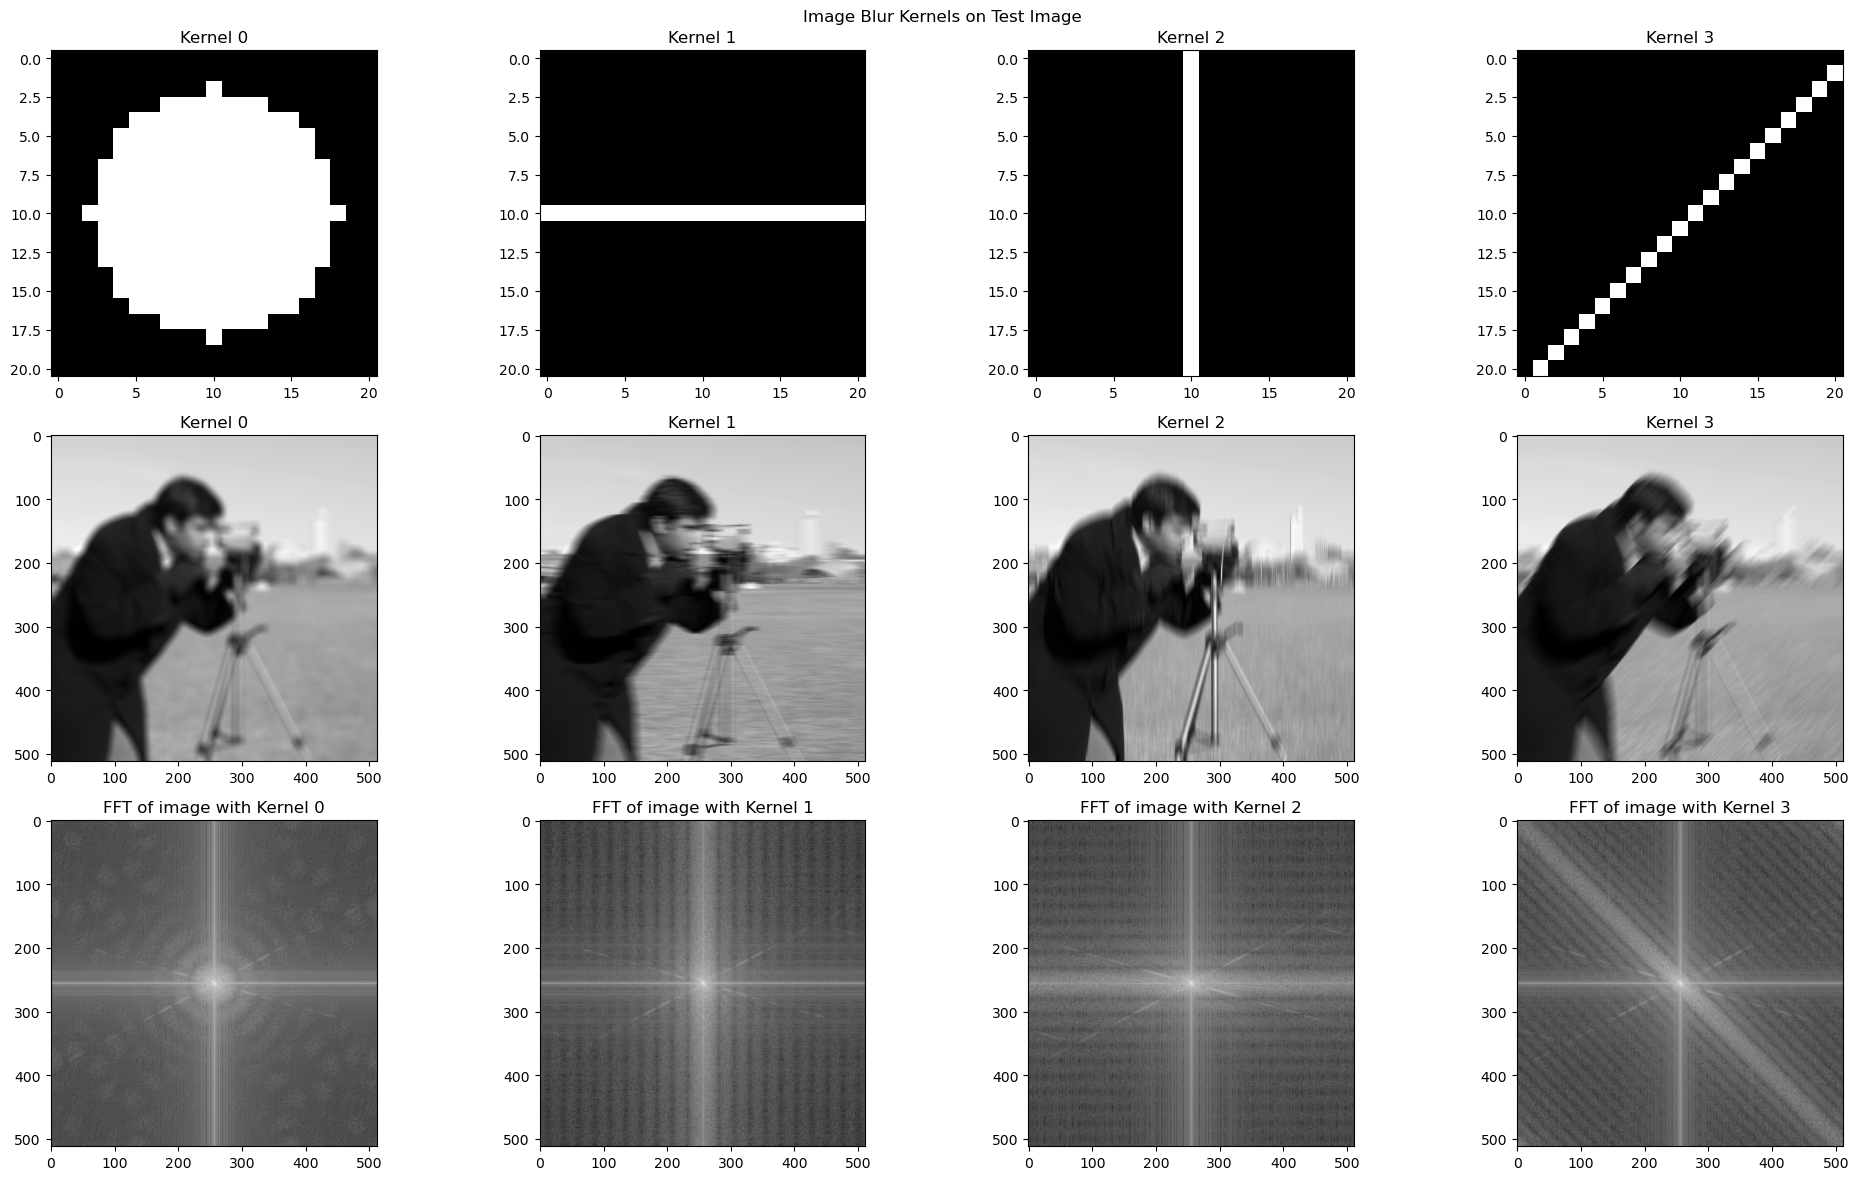

In [100]:
fig, ax = plt.subplots(3, 4, figsize=(20, 12))

fig.suptitle("Image Blur Kernels on Test Image")

for i, k in enumerate(kernels):
    blurred = cv2.filter2D(image, ddepth=-1, kernel=kernels[i]/255)
    blurred_fft = np.fft.fft2(blurred)

    ax[0][i].imshow(k, cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(blurred, cmap='gray')
    ax[1][i].set_title(f"Kernel {i}")
    ax[2][i].imshow(np.log(np.abs(np.fft.fftshift(blurred_fft))), cmap='gray')
    ax[2][i].set_title(f"FFT of image with Kernel {i}")

plt.tight_layout();

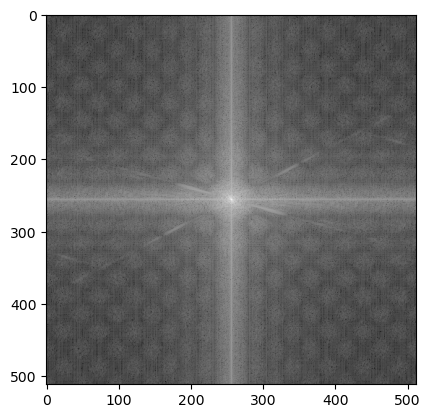

In [150]:
plt.imshow(np.log(np.abs(np.fft.fftshift(blurred_fft))), cmap='gray');

### Now let's make a function to Blur Images in any direction that we want!

In [49]:
def get_motion_blur_kernel(x, y, thickness=1, ksize=21):
    """ Obtains Motion Blur Kernel
        Inputs:
            x - horizontal direction of blur
            y - vertical direction of blur
            thickness - thickness of blur kernel line
            ksize - size of blur kernel
        Outputs:
            blur_kernel
        """
    blur_kernel = np.zeros((ksize, ksize))
    c = int(ksize/2)

    blur_kernel = np.zeros((ksize, ksize))

    return cv2.line(blur_kernel, pt1=(c+x,c+y), pt2=(c,c), color=(255,), thickness=thickness)


In [81]:
blur_kernel = get_motion_blur_kernel(x=-25, y=15, thickness=1, ksize=31)
blurred = cv2.filter2D(image, ddepth=-1, kernel=blur_kernel)
blur_kernel_fft = np.fft.fftshift(np.fft.fft2(blur_kernel))

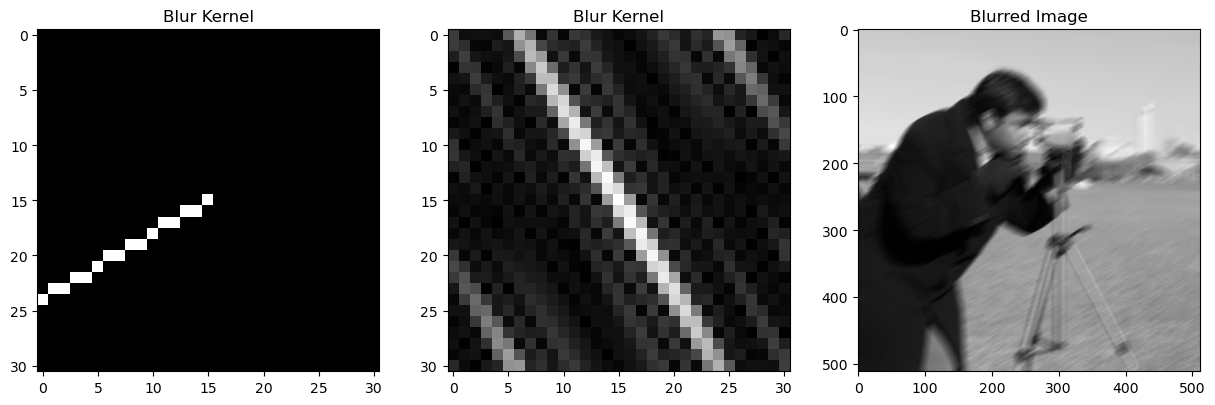

In [84]:
_, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(blur_kernel, cmap='gray')
ax[0].set_title("Blur Kernel")
ax[1].imshow(np.abs(blur_kernel_fft), cmap='gray')
ax[1].set_title("Blur Kernel FFT")
ax[2].imshow(blurred, cmap='gray')
ax[2].set_title("Blurred Image");

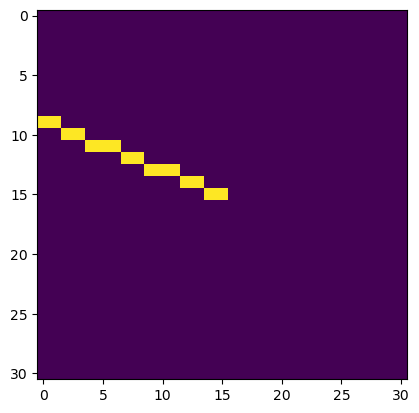

In [63]:
plt.imshow(blur_kernel);

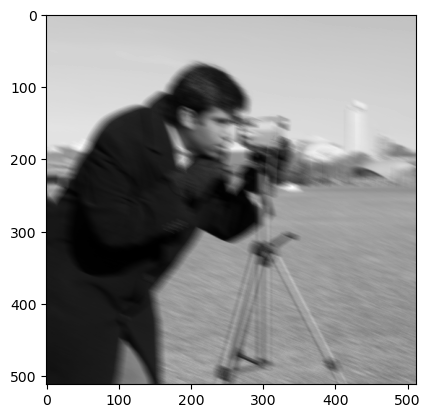

In [64]:
plt.imshow(blurred, cmap='gray');

We can also apply the Blur in the Frequency Domain

In [140]:
# pad image
pad = 64
h, w = image.shape
padded_image = np.zeros((h + 2*pad, w + 2*pad))
padded_image[pad:-pad, pad:-pad] = image

# compute and store FFT of padded test image
F = np.fft.fft2(padded_image)

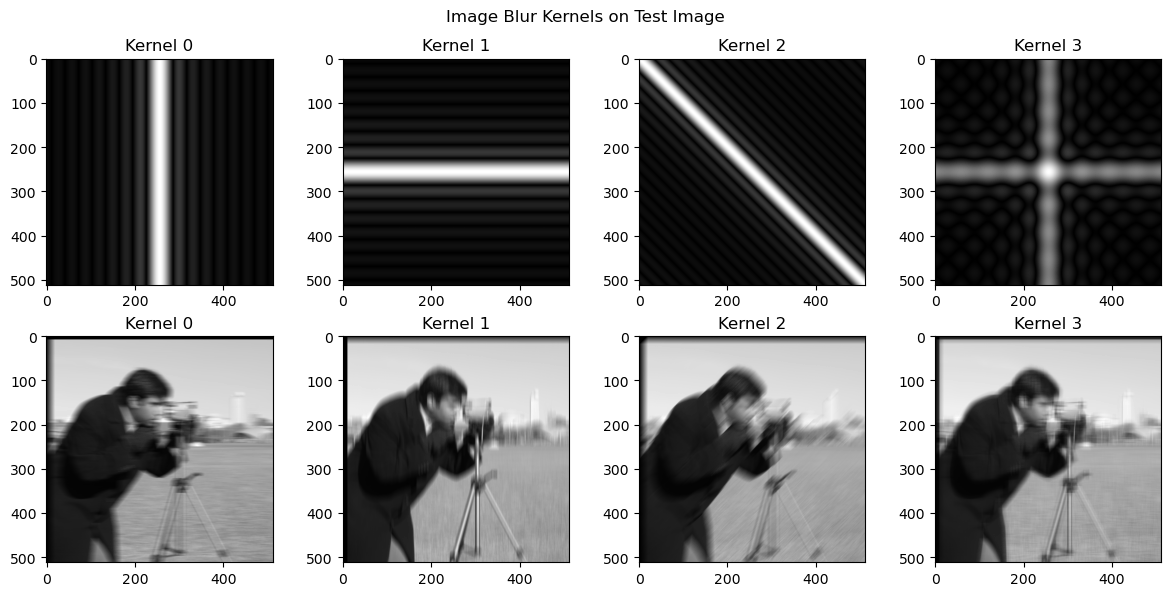

In [141]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

fig.suptitle("Image Blur Kernels on Test Image")

for i, k in enumerate(kernels):
    # Zero Pad Kernel
    zp_kernel = np.zeros_like(padded_image)
    h, w = kernels[i].shape
    zp_kernel[0:h, 0:w] = kernels[i]

    # Get FFT of Zero Padded kernel
    k_fft = np.fft.fft2(zp_kernel)

    # Blur Image in Frequency Domain
    blurred_fft = F * k_fft

    # Get IFFT 
    blurred = np.abs(np.fft.ifft2(blurred_fft))

    ax[0][i].imshow(np.abs(np.fft.fftshift(k_fft))[pad:-pad, pad:-pad], cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(blurred[pad:-pad, pad:-pad], cmap='gray')
    ax[1][i].set_title(f"Kernel {i}")

plt.tight_layout();

## Get Ground Truth Image Blur Kernels

Now we will apply some image blur kernels used in common deblurring papers. These Blur Kernels originally appeared in this [paper](https://dspace.mit.edu/bitstream/handle/1721.1/59815/Levin-2009-Understanding%20and%20evaluating%20blind%20deconvolution%20algorithms.pdf), but they can be found in this Github repo or at this [location](https://cs.brown.edu/people/lbsun/deblur2013/deblur2013iccp.html)

In [126]:
kernel_paths = glob(os.path.join('../blur_kernels', '*.png'))
kernels = [cv2.imread(kpath, cv2.IMREAD_UNCHANGED) for kpath in kernel_paths]

In [127]:
for k in kernels:
    print(k.shape)

(19, 19)
(17, 17)
(15, 15)
(27, 27)
(13, 13)
(21, 21)
(23, 23)
(23, 23)


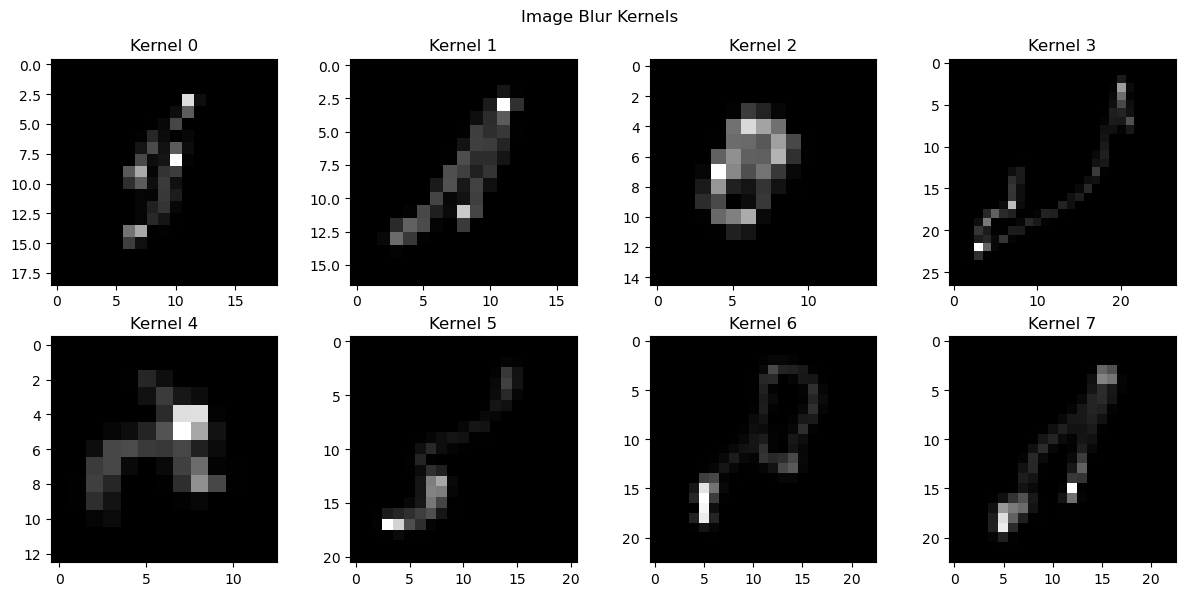

In [128]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

fig.suptitle("Image Blur Kernels")

for i in range(4):
    ax[0][i].imshow(kernels[i], cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(kernels[i+4], cmap='gray')
    ax[1][i].set_title(f"Kernel {i+4}")

plt.tight_layout();

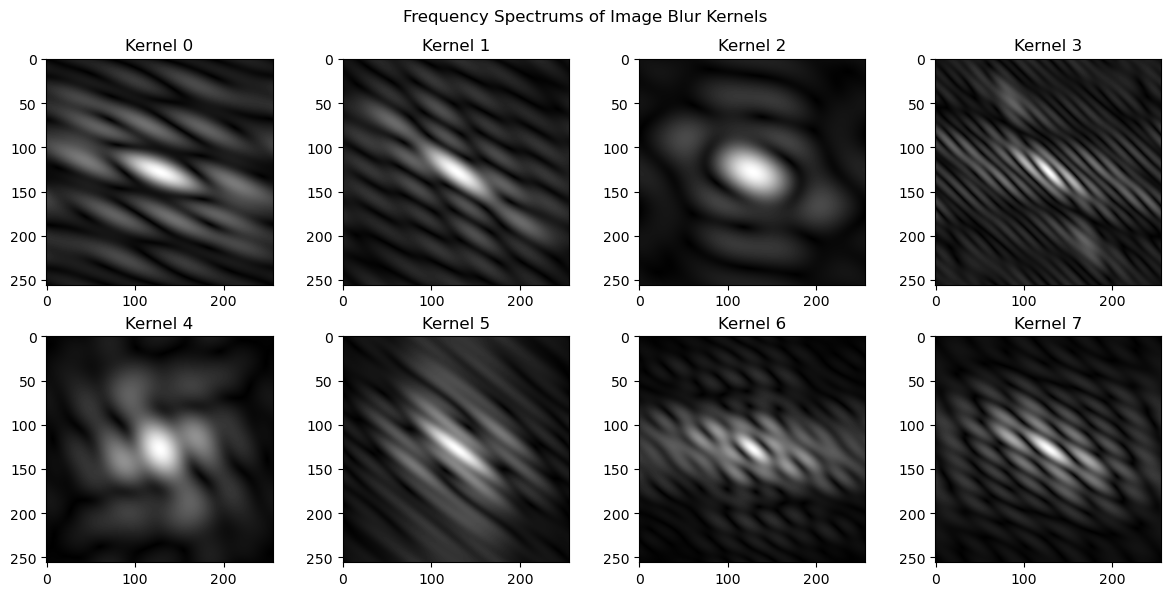

In [129]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

fig.suptitle("Frequency Spectrums of Image Blur Kernels")

for i in range(4):
    # regular 
    # k_fft_0 = np.fft.fft2(kernels[i])
    # k_fft_1 = np.fft.fft2(kernels[i+4])

    # Zero Padded
    canvas_0 = np.zeros((256, 256))
    canvas_1 = np.zeros((256, 256))

    h0, w0 = kernels[i].shape
    h1, w1 = kernels[i+4].shape

    canvas_0[0:h0, 0:w0] = kernels[i]
    canvas_1[0:h1, 0:w1] = kernels[i+4]

    k_fft_0 = np.fft.fft2(canvas_0)
    k_fft_1 = np.fft.fft2(canvas_1)
    

    ax[0][i].imshow(np.abs(np.fft.fftshift(k_fft_0)), cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(np.abs(np.fft.fftshift(k_fft_1)), cmap='gray')
    ax[1][i].set_title(f"Kernel {i+4}")

plt.tight_layout();

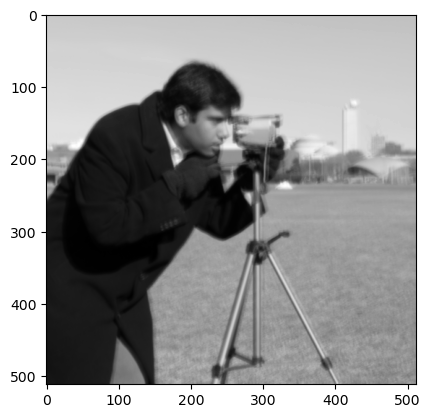

In [130]:
tmp = cv2.filter2D(image, ddepth=-1, kernel=kernels[4]/255)

plt.imshow(tmp, cmap='gray');

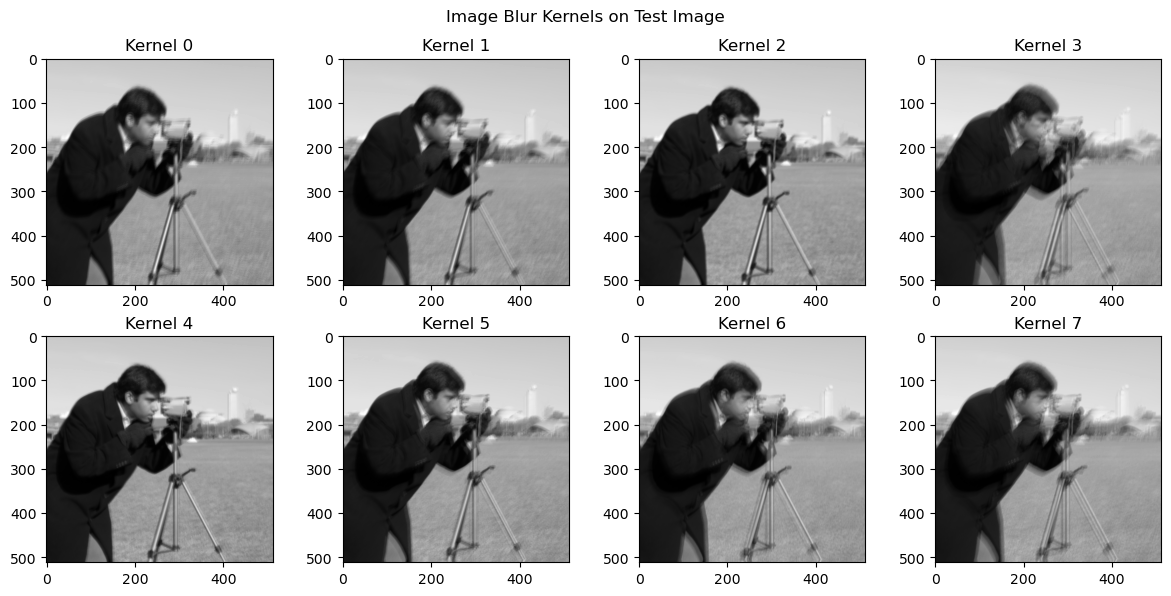

In [131]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

fig.suptitle("Image Blur Kernels on Test Image")

for i in range(4):
    blurred_0 = cv2.filter2D(image, ddepth=-1, kernel=kernels[i]/255)
    blurred_1 = cv2.filter2D(image, ddepth=-1, kernel=kernels[i+4]/255)
    ax[0][i].imshow(blurred_0, cmap='gray')
    ax[0][i].set_title(f"Kernel {i}")
    ax[1][i].imshow(blurred_1, cmap='gray')
    ax[1][i].set_title(f"Kernel {i+4}")

plt.tight_layout();